In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.regularizers import l1

import cv2
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from time import time
import numpy as np

In [47]:
df = pd.read_json("../processed/known_data.json")

In [3]:
df.head()

,category,im_path
0,normal,normal_0.png
1,normal,normal_1.png
2,normal,normal_10.png
3,normal,normal_101.png
4,normal,normal_102.png


In [4]:
KNOWN_IMAGES = "../data/dataset1/known_images/"

In [5]:
lbr = preprocessing.LabelBinarizer().fit(df.category)

In [6]:
import pickle

In [7]:
with open('binarizer', 'wb') as handle:
    pickle.dump(lbr,handle)

In [8]:
df['label'] = lbr.transform(df.category)

In [9]:
new_df = df.copy()

In [10]:
new_df.drop("category",axis=1,inplace=True)

In [11]:
new_df

,im_path,label
0,normal_0.png,0
1,normal_1.png,0
2,normal_10.png,0
3,normal_101.png,0
4,normal_102.png,0
...,...,...
710,sick_94.png,1
711,sick_96.png,1
712,sick_97.png,1
713,sick_98.png,1


In [12]:
train, valid = train_test_split(new_df, test_size=0.2, random_state=1)

In [13]:
train

,im_path,label
622,sick_349.png,1
600,sick_328.png,1
709,sick_93.png,1
664,sick_5.png,1
449,sick_180.png,1
...,...,...
144,normal_233.png,0
645,sick_37.png,1
72,normal_165.png,0
235,normal_318.png,0


In [14]:
train_data = {"features":[],"labels":[]}
test_data = {"features":[],"lables":[]}

In [15]:
def read_img(file_path:str):
    img_gray = cv2.imread(KNOWN_IMAGES+file_path,cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(img_gray, (128,128), interpolation = cv2.INTER_AREA)
    im_bw = cv2.threshold(resized, 127, 255, cv2.THRESH_BINARY)[1]
    return im_bw

In [16]:
import matplotlib.pyplot as plt

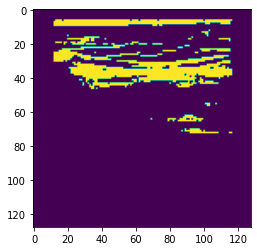

In [17]:
plt.imshow(read_img("normal_165.png"))

In [18]:
train_data['labels'] = train['label']

In [19]:
train_data['features'] = train.im_path.apply(lambda x: read_img(x))

In [20]:
test_data['lables'] = valid['label']

In [21]:
test_data['features'] = valid.im_path.apply(lambda x: read_img(x))

In [22]:
X_features = []
for i in train_data['features']:
    k = i.reshape((i.shape[0], i.shape[1], 1))
    X_features.append(k)

In [23]:
X_features = np.stack(X_features, axis=0)

In [24]:
X_features.shape

(572, 128, 128, 1)

In [25]:
X_labels = []
for i in train_data['labels']:
    X_labels.append(i)

In [26]:
X_labels = np.reshape(X_labels, (len(X_labels),-1))

In [27]:
Y_features = []
for i in test_data['features']:
    k = i.reshape((i.shape[0], i.shape[1], 1))
    Y_features.append(k)

In [28]:
Y_features = np.stack(Y_features,axis=0)

In [29]:
Y_labels = []
for i in test_data['lables']:
    Y_labels.append(i)

In [30]:
Y_labels = np.reshape(Y_labels, (len(Y_labels),-1))

In [63]:
model = Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(128,128,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu',kernel_regularizer=l1(0.1)))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=1, activation = 'sigmoid'))

In [64]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 6)       60        
                                                                 
 average_pooling2d_6 (Averag  (None, 63, 63, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 16)        880       
                                                                 
 average_pooling2d_7 (Averag  (None, 30, 30, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 14400)             0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [65]:
bce = keras.losses.BinaryCrossentropy(from_logits=False)

In [66]:
model.compile(loss=bce, optimizer=keras.optimizers.adam_v2.Adam(), metrics=['accuracy'])

In [67]:
EPOCHS = 18
BATCH_SIZE = 30

In [68]:
train_generator = ImageDataGenerator(shear_range=0.4,
        zoom_range=0.4,horizontal_flip=True).flow(X_features, X_labels, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(Y_features, Y_labels, batch_size=BATCH_SIZE)

In [69]:
steps_per_epoch = X_features.shape[0]//BATCH_SIZE
validation_steps = Y_features.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

C:\Users\Taufeeq\AppData\Local\Temp/ipykernel_19804/425097378.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,


Epoch 1/18
19/19 [==============================] - 2s 74ms/step - loss: 807.7003 - accuracy: 0.7306 - val_loss: 252.8042 - val_accuracy: 0.8583
Epoch 2/18
19/19 [==============================] - 1s 62ms/step - loss: 168.8263 - accuracy: 0.7565 - val_loss: 87.4602 - val_accuracy: 0.8333
Epoch 3/18
19/19 [==============================] - 1s 62ms/step - loss: 56.6193 - accuracy: 0.7786 - val_loss: 36.3230 - val_accuracy: 0.8583
Epoch 4/18
19/19 [==============================] - 1s 64ms/step - loss: 30.9366 - accuracy: 0.7509 - val_loss: 27.0769 - val_accuracy: 0.7000
Epoch 5/18
19/19 [==============================] - 1s 64ms/step - loss: 25.4729 - accuracy: 0.7325 - val_loss: 24.2663 - val_accuracy: 0.8167
Epoch 6/18
19/19 [==============================] - 1s 63ms/step - loss: 23.8100 - accuracy: 0.7989 - val_loss: 23.6580 - val_accuracy: 0.9000
Epoch 7/18
19/19 [==============================] - 1s 63ms/step - loss: 23.2745 - accuracy: 0.7657 - val_loss: 23.4985 - val_accuracy: 0.8

In [70]:
model.save("./lenet-95")

INFO:tensorflow:Assets written to: ./lenet-95\assets


In [71]:
from sklearn.metrics import precision_score, recall_score

In [72]:
y_pred = model.predict(Y_features)

In [73]:
y_pred = list(map(lambda x: 0 if x<0.5 else 1, y_pred))

In [74]:
precision_score(Y_labels,y_pred)

0.8709677419354839

In [75]:
recall_score(Y_labels,y_pred)

0.782608695652174